In [11]:
import numpy as np
import pandas as pd
import os
import numpy as np
from IPython.display import YouTubeVideo

import requests
import json

import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from scipy.signal import peak_prominences
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch

import ruptures as rpt

In [3]:
path = r"/Users/scottmerrill/Documents/UNC/MultiModal/VMR/Youtube8m"
filenames = os.listdir(path + '/video')

In [4]:
def sample_dataset(filename):
    video_data = np.load(path + f'/video/{filename}')
    audio_data = np.load(path + f'/audio/{filename}')
    video_data = video_data[:,:1024] # we still need to do pca whitening so leaving this for now
    return torch.tensor(video_data), torch.tensor(audio_data)

### Optical Flow Based Segmentation

In [26]:
# Function to calculate the optical flow using Euclidean distance between successive frames
def calculate_optical_flow_euclidean(embedding_seq):
    # Calculate the Euclidean distance between successive frames
    return np.linalg.norm(embedding_seq[1:] - embedding_seq[:-1], axis=1)

# Function to find local maxima and minima, ensuring that they are at least `min_dist` frames apart
def find_local_maxima_minima(flow, num_peaks=10, min_dist=10):
    # Find local maxima (peaks) and minima (valleys) in the optical flow
    maxima, _ = find_peaks(flow)
    minima, _ = find_peaks(-flow)  # Minima are the negative peaks

    # Combine maxima and minima
    all_peaks = np.concatenate((maxima, minima))

    # Sort all detected peaks
    all_peaks_sorted = np.sort(all_peaks)

    # Ensure that peaks are at least `min_dist` apart
    valid_peaks = [all_peaks_sorted[0]]  # Start with the first peak
    for i in range(1, len(all_peaks_sorted)):
        if all_peaks_sorted[i] - valid_peaks[-1] >= min_dist:
            valid_peaks.append(all_peaks_sorted[i])

    # Ensure we return no more than `num_peaks` peaks
    if len(valid_peaks) > num_peaks:
        valid_peaks = valid_peaks[:num_peaks]

    return np.array(valid_peaks)

# Function to create segments based on detected peaks
def create_segments_from_peaks(flow, num_segments=10, min_dist=10):
    # Find local maxima/minima to be used as segment boundaries
    peak_indices = find_local_maxima_minima(flow, num_peaks=num_segments, min_dist=min_dist)

    # Ensure that we always include the start (0) and end (len(flow)) of the video
    segment_boundaries = np.concatenate(([0], peak_indices, [len(flow)]))

    return segment_boundaries


# Function to compute a moving average of the flow
def moving_average(arr, window_size=5):
    """
    Compute the moving average of the given array using a window of size `window_size`.
    """
    return np.convolve(arr, np.ones(window_size) / window_size, mode='valid')

def merge_intervals(arr, minsize):
    # Ensure the array is sorted (if it is not already)
    arr = np.sort(arr)

    merged = [arr[0]]  # Start with the first element

    for i in range(1, len(arr)):
        # If the difference between consecutive elements is less than minsize, merge them
        if arr[i] - merged[-1] < minsize:
            continue  # Skip adding the current element (effectively merging)
        else:
            merged.append(arr[i])  # Otherwise, add the element to the merged list

    return np.array(merged)


def rank_averages(averages):
    # Get the indices that would sort the averages array in descending order
    sorted_indices = np.argsort(averages)[::-1]

    # Create an array to hold the ranks
    ranks = np.zeros_like(sorted_indices) + 1  # Initialize all ranks to 1

    # Assign ranks based on sorted order
    for rank, idx in enumerate(sorted_indices):
        ranks[idx] = rank + 1  # Assign the rank, +1 because ranking starts at 1

    return ranks

import numpy as np

def compute_segment_means(segments, other_array):
    """
    Computes the mean of `other_array` values for each segment defined by `segments`.
    If a segment extends beyond the bounds of `other_array`, the mean will be 0 for that segment.

    Parameters:
    - segments (np.array): Array of segment boundaries (must be in increasing order).
    - other_array (np.array): Array of values to calculate the mean over.

    Returns:
    - List of means for each segment.
    """
    # Length of the other_array
    array_length = len(other_array)

    averages = []

    # Process the middle segments
    for i in range(1, len(segments)):
        start_idx = segments[i-1]
        end_idx = segments[i]

        # Adjust the end index if it's out of bounds
        if end_idx > array_length:
            end_idx = array_length

        # If the range is valid (start < end), compute the mean; else, return 0
        if start_idx < end_idx:
            segment_mean = other_array[start_idx:end_idx].mean()
        else:
            segment_mean = 0

        averages.append(segment_mean)

    return averages

def optical_flow_segments(optical_flow, max_segments=10, min_frames=10):
    # calculate peaks and prominences
    peaks, _ = find_peaks(optical_flow)
    prominences = peak_prominences(optical_flow, peaks)[0]
    prominences = prominences.argsort()
    peak_index = peaks[prominences[-max_segments:]]
    peak_index.sort()

    # merge so they have a minimum distance of min_frames
    peak_index_final = merge_intervals(peak_index, min_frames)
    #peak_index_final.insert(0, 0)
    peak_index_final = np.insert(peak_index_final, 0, 0)
    peak_index_final = np.append(peak_index_final, len(optical_flow))
    return peak_index_final


def get_change_points(optical_flow_video, min_segments, max_seq_len=100):
    
    while True:
        algo = rpt.Dynp(model='l2', min_size=10, jump=3).fit(optical_flow_video)
        change_points = algo.predict(n_bkps=min_segments)  # The 'pen' parameter controls sensitivity
        differences = [change_points[i+1] - change_points[i] for i in range(len(change_points)-1)]

        if max(differences) < max_seq_len:
            break
        else:
            min_segments += 1
            
    # insert zero for start segment
    change_points.insert(0,0)
    return change_points

In [27]:
max_seq_len = 100
rgb_frames, audio_sample_pos = sample_dataset(filenames[np.random.randint(len(filenames))])
_, audio_sample_neg1 = sample_dataset(filenames[np.random.randint(len(filenames))])
_, audio_sample_neg2 = sample_dataset(filenames[np.random.randint(len(filenames))])

In [28]:
# Calculate optical flow using cosine similarity
optical_flow_video = calculate_optical_flow_euclidean(rgb_frames)
optical_flow_video = moving_average(optical_flow_video, window_size=10)

optical_flow_audio_pos = calculate_optical_flow_euclidean(audio_sample_pos)
optical_flow_audio_pos = moving_average(optical_flow_audio_pos, window_size=10)

optical_flow_audio_neg1 = calculate_optical_flow_euclidean(audio_sample_neg1)
optical_flow_audio_neg1 = moving_average(optical_flow_audio_neg1, window_size=10)

optical_flow_audio_neg2 = calculate_optical_flow_euclidean(audio_sample_neg2)
optical_flow_audio_neg2 = moving_average(optical_flow_audio_neg2, window_size=10)

# Segment the video based on regime changes in optical flow
segments = get_change_points(optical_flow_video, min_segments=5, max_seq_len=max_seq_len)

### Compute optical flow ranks and norm diffs

In [29]:
segment_ranks_video = rank_averages(compute_segment_means(segments, optical_flow_video))
segment_ranks_audio_pos = rank_averages(compute_segment_means(segments, optical_flow_audio_pos))
segment_ranks_audio_neg1 = rank_averages(compute_segment_means(segments, optical_flow_audio_neg1))
segment_ranks_audio_neg2 = rank_averages(compute_segment_means(segments, optical_flow_audio_neg2))

print(segment_ranks_video)
print(segment_ranks_audio_pos)
print(segment_ranks_audio_neg1)
print(segment_ranks_audio_neg2)

norm_diff_pos = round(np.linalg.norm(segment_ranks_video-segment_ranks_audio_pos), 2)
norm_diff_neg1 = round(np.linalg.norm(segment_ranks_video-segment_ranks_audio_neg1), 2)
norm_diff_neg2 = round(np.linalg.norm(segment_ranks_video-segment_ranks_audio_neg2), 2)

print(norm_diff_pos)
print(norm_diff_neg1)
print(norm_diff_neg2)

[2 5 1 3 6 4]
[4 2 1 3 5 6]
[5 4 2 1 3 6]
[6 3 5 4 2 1]
4.24
5.29
7.87


### Plot Result

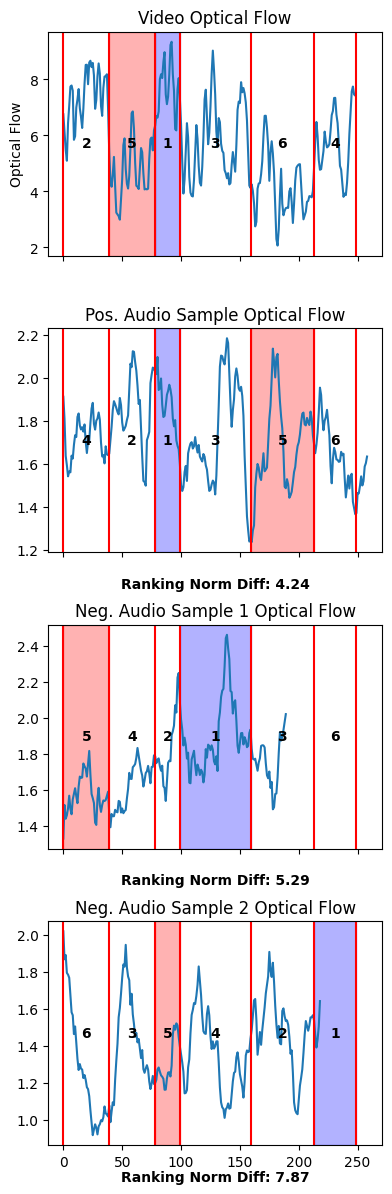

In [30]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(4, 12))

# Data lists
data_lists = [optical_flow_video, optical_flow_audio_pos, optical_flow_audio_neg1, optical_flow_audio_neg2]
titles = ['Video Optical Flow', 'Pos. Audio Sample Optical Flow', 'Neg. Audio Sample 1 Optical Flow', 'Neg. Audio Sample 2 Optical Flow']
ranking_lists = [segment_ranks_video, segment_ranks_audio_pos, segment_ranks_audio_neg1, segment_ranks_audio_neg2]
norm_diffs = [None, norm_diff_pos, norm_diff_neg1, norm_diff_neg2]  # None for the first subplot as it doesn't have norm_diff

for i, (ax, data, title, rankings, norm_diff) in enumerate(zip(axes, data_lists, titles, ranking_lists, norm_diffs)):
    # Plot data and set title
    ax.plot(data)
    ax.set_title(title)
    #ax.set_xlabel('Frame')
    if i == 0:
        ax.set_ylabel('Optical Flow')

    # Get the full visible y-axis range after plotting
    ymin, ymax = ax.get_ylim()

    # Plot vertical lines for segments
    for peak in segments:
        ax.axvline(peak, ymin=0, ymax=1, color='r')

    # Add rankings and highlight segments
    for j in range(len(segments) - 1):
        midpoint = (segments[j] + segments[j + 1]) / 2
        
        if midpoint >= ax.get_xlim()[0] and midpoint <= ax.get_xlim()[1]:
            # Add ranking text
            ax.text(midpoint, (ymin + ymax) / 2, rankings[j], ha='center', va='center', fontweight='bold')
            
            # Highlight segments ranked 1 (blue) and 5 (red)
            if rankings[j] == 1:
                ax.fill_betweenx([ymin, ymax], segments[j], segments[j+1], color='blue', alpha=0.3)
            elif rankings[j] == 5:
                ax.fill_betweenx([ymin, ymax], segments[j], segments[j+1], color='red', alpha=0.3)

    # Ensure the y-axis limits remain the same after filling
    ax.set_ylim(ymin, ymax)

    # Add norm diff text (except for the first subplot)
    if i > 0:
        ax.text(0.5, -0.11, f'Ranking Norm Diff: {norm_diff}', ha='center', fontweight='bold', va='top', transform=ax.transAxes)

# Adjust layout to avoid overlapping
plt.tight_layout(pad=1)
plt.savefig('Segment.png')

In [87]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_rankings(upper_ranks, lower_ranks, upper_label, lower_label):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Layout parameters
    block_width = 0.15
    block_height = 0.15
    spacing = 0.03
    total_width = 5 * block_width + 4 * spacing
    start_x = (1 - total_width) / 2
    upper_y = 0.65
    lower_y = 0.25

    def get_color(rank):
        return 'red' if rank == 5 else 'blue' if rank == 1 else 'white'

    # Plot blocks and add text
    for i, (ur, lr) in enumerate(zip(upper_ranks, lower_ranks)):
        x = start_x + i * (block_width + spacing)
        
        # Upper block
        upper_block = patches.Rectangle(
            (x, upper_y), block_width, block_height,
            facecolor=get_color(ur), edgecolor='black', linewidth=1
        )
        ax.add_patch(upper_block)
        ax.text(x + block_width/2, upper_y + block_height/2, str(ur),
                ha='center', va='center', fontsize=12, fontweight='bold')
        
        # Lower block
        lower_block = patches.Rectangle(
            (x, lower_y), block_width, block_height,
            facecolor=get_color(lr), edgecolor='black', linewidth=1
        )
        ax.add_patch(lower_block)
        ax.text(x + block_width/2, lower_y + block_height/2, str(lr),
                ha='center', va='center', fontsize=12, fontweight='bold')

    # Connect red blocks (rank 5)
    upper_red_idx = upper_ranks.index(5)
    lower_red_idx = lower_ranks.index(5)
    ax.plot(
        [start_x + upper_red_idx*(block_width+spacing) + block_width/2,
         start_x + lower_red_idx*(block_width+spacing) + block_width/2],
        [upper_y, lower_y + block_height],
        color='red', linewidth=2
    )

    # Connect blue blocks (rank 1)
    upper_blue_idx = upper_ranks.index(1)
    lower_blue_idx = lower_ranks.index(1)
    ax.plot(
        [start_x + upper_blue_idx*(block_width+spacing) + block_width/2,
         start_x + lower_blue_idx*(block_width+spacing) + block_width/2],
        [upper_y, lower_y + block_height],
        color='blue', linewidth=2
    )

    # Add labels above and below the arrays
    ax.text(0.5, 0.85, upper_label, ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(0.5, 0.15, lower_label, ha='center', va='center', fontsize=14, fontweight='bold')

    # Configure plot appearance
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    plt.tight_layout()
    plt.savefig('OF_Ranking_Graph.png')
    plt.show()

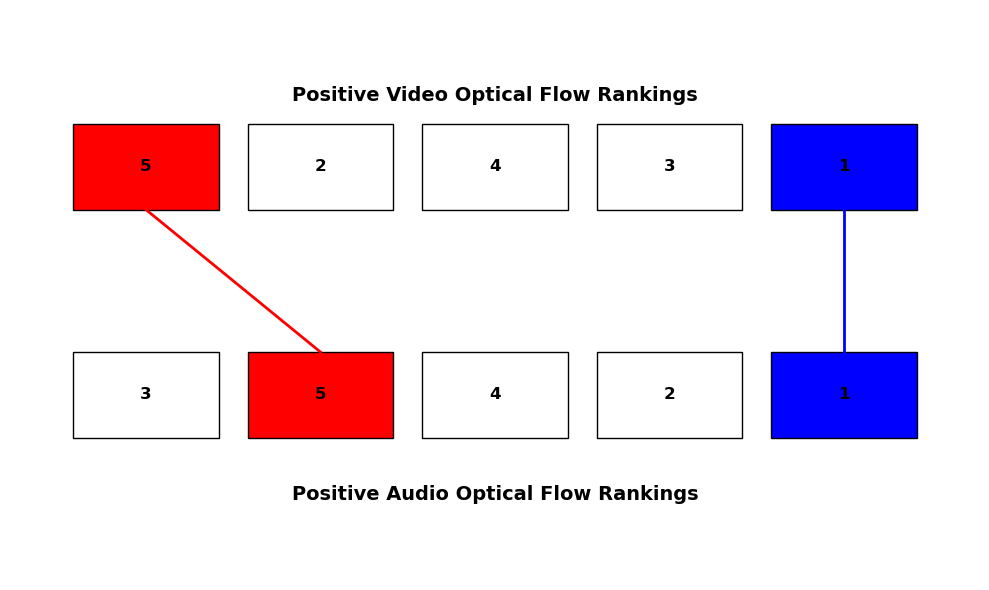

In [14]:
# Example usage
plot_rankings(list(segment_ranks_video), list(segment_ranks_audio_pos), 
              "Positive Video Optical Flow Rankings", 
              "Positive Audio Optical Flow Rankings")

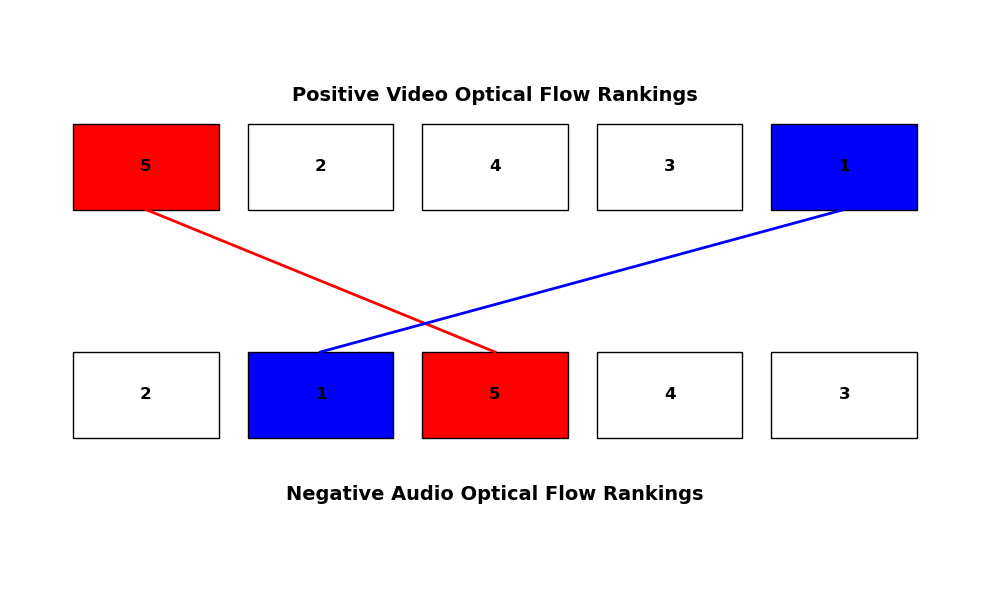

In [15]:
# Example usage
plot_rankings(list(segment_ranks_video), list(segment_ranks_audio_neg1), 
              "Positive Video Optical Flow Rankings", 
              "Negative Audio Optical Flow Rankings")

In [49]:
segments = optical_flow_segments(optical_flow_video, max_segments=4)

In [50]:
segments

array([  0,  81, 167, 192, 262, 280])

In [10]:
!pip install ruptures


### Pelt Change Points

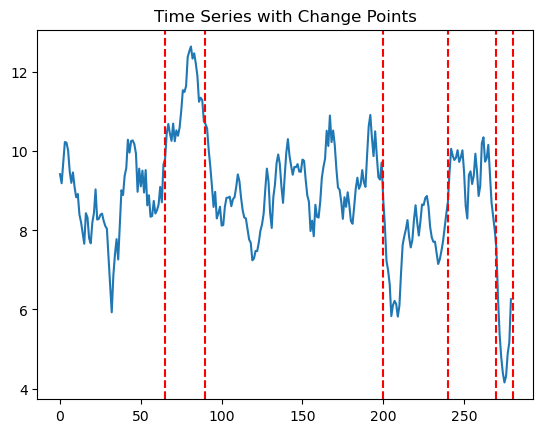

In [67]:
model = "l2"  # 'l2' corresponds to detecting changes in the mean (sum of squared errors)
algo = rpt.Pelt(model=model).fit(optical_flow_video)

# with this we can't control exat number of segments
change_points = algo.predict(pen=20)  # The 'pen' parameter controls sensitivity

plt.clf()
plt.plot(optical_flow_video)
plt.title("Time Series with Change Points")
for cp in change_points:
    plt.axvline(cp, color="red", linestyle="--")
plt.show()

### Dynamic Programming Change Pointsm

In [ ]:
algo = rpt.Dynp(model='l2', min_size=3, jump=5).fit(optical_flow_video)
change_points = algo.predict(n_bkps=5)  # The 'pen' parameter controls sensitivity

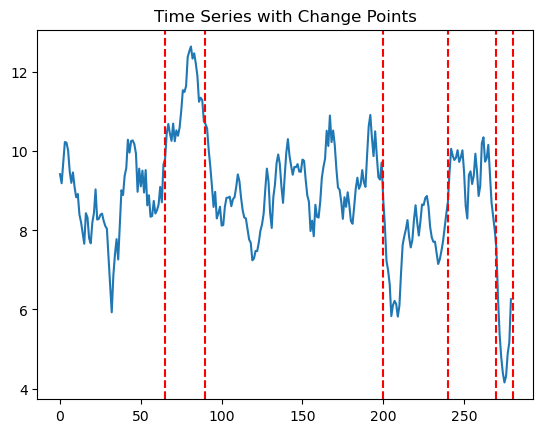

In [69]:
plt.clf()
plt.plot(optical_flow_video)
plt.title("Time Series with Change Points")
for cp in change_points:
    plt.axvline(cp, color="red", linestyle="--")
plt.show()



### Kernel based

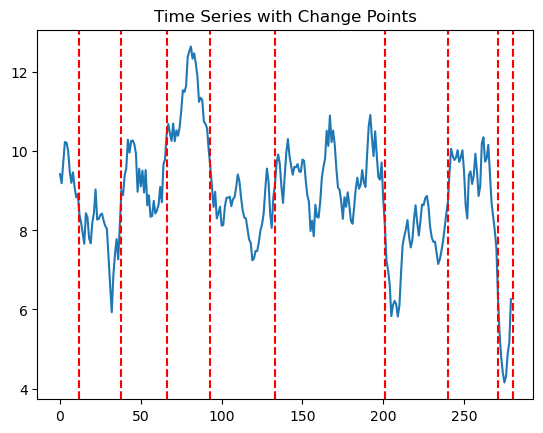

In [79]:
algo = rpt.KernelCPD(kernel="linear").fit(optical_flow_video)
change_points = algo.predict(8)  # The 'pen' parameter controls sensitivity

plt.clf()
plt.plot(optical_flow_video)
plt.title("Time Series with Change Points")
for cp in change_points:
    plt.axvline(cp, color="red", linestyle="--")
plt.show()
